<a href="https://colab.research.google.com/github/HinePo/OCR-with-Tesseract-example/blob/main/OCR_Tesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tesseract OCR: Extracting texts from images

This is a notebook that uses pytesseract to do OCR (Optical Character Recognition). It iterates over a parent directory, going inside of every subfolder and processing every file contained in each subfolder.

For each image file (jpg, png) that is processed, it outputs a copy of the image with all bounding boxes drawn, and also a .txt file with all text detected by tesseract, and saves both files in a directory you choose, with the same filename as the source image.

For each pdf that is processed, it outputs the detected and extracted text from all pages, concatenated in a single .txt file. At the moment it does not output the drawn bounding boxes for each page so it doesn't mess up the directory in case of pdf files with thousands of pages.

Obs.: Obviously, you will need to change your paths for this to work on your files.

Some useful resources are listed below:

**Tesseract**
- https://pypi.org/project/pytesseract/
- https://www.kaggle.com/suyogdahal/ocr-using-tesseract


**Handling pdf with many pages**
- https://stackoverflow.com/questions/60754884/python-ocr-pytesseract-for-pdf
- https://www.geeksforgeeks.org/python-reading-contents-of-pdf-using-ocr-optical-character-recognition/

**Image processing**
- https://nanonets.com/blog/ocr-with-tesseract/#preprocessingfortesseract
- https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
- https://medium.com/analytics-vidhya/python-how-image-processing-for-ocr-using-opencv-966acfae07a6


# Setup

In [1]:
%%time
!pip install pdf2image

CPU times: user 31 ms, sys: 11.2 ms, total: 42.2 ms
Wall time: 2.94 s


In [2]:
%%time
!apt-get install poppler-utils 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
CPU times: user 35.2 ms, sys: 14.1 ms, total: 49.3 ms
Wall time: 2.33 s


In [3]:
%%time
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
CPU times: user 76 ms, sys: 28.8 ms, total: 105 ms
Wall time: 5.27 s


In [4]:
import pytesseract
from pytesseract import Output

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import Image
from pylab import rcParams

import pdf2image
from pdf2image import convert_from_path, convert_from_bytes
from tqdm import tqdm

In [6]:
rcParams['figure.figsize'] = 10, 20

# Image processing

In [7]:
# RGB -> BGR
def rgb_to_bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB (cv2 default) -> BGR (real colors)
# openCV uses BGR (imread, imwrite, imshow)
# matplotlib uses RGB (plt.imshow)

# get grayscale from RGB image
def rgb_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # RGB -> gray

# get grayscale from GBR image
def bgr_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # BGR -> gray

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
      angle = -(90 + angle)
    else:
      angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

# Path config

In [8]:
path = '/content/drive/MyDrive/Colab Files/ocr tesseract images'

folder_list = []

for folder in os.listdir(path):
  folder_list.append(folder)
print(folder_list)

output_path ='/content/drive/MyDrive/Colab Files/ocr tesseract output'

['t2', 't1']


In [9]:
## count number of files
print("Number of files in path:", sum([len(files) for r, d, files in os.walk(path)]))
print("Number of files in output_path:", sum([len(files) for r, d, files in os.walk(output_path)]))

Number of files in path: 4
Number of files in output_path: 0


# Tesseract example

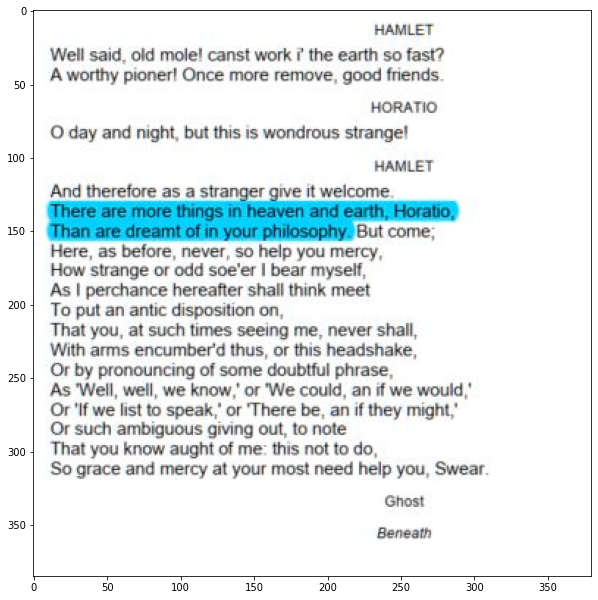

In [10]:
img = cv2.imread("/content/drive/MyDrive/Colab Files/ocr tesseract images/t1/img001.JPG")
plt.imshow(img)

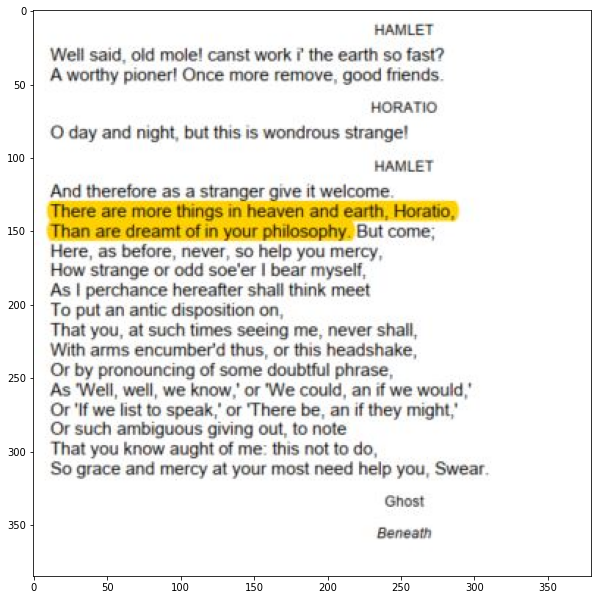

In [11]:
img2 = rgb_to_bgr(img) # to original colors
plt.imshow(img2)

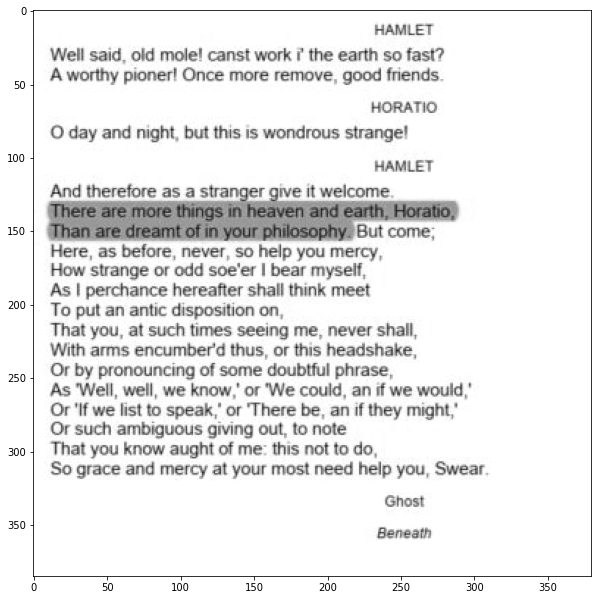

In [12]:
img3 = rgb_to_gray(img)
plt.imshow(img3, cmap='gray', vmin=0, vmax=255) # display in grayscale in matplotlib

In [13]:
d = pytesseract.image_to_data(img, output_type = Output.DICT)
print(d.keys()) # all properties from image_to_data method

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [14]:
pytesseract.image_to_string(img)

"HAMLET\n\nWell said, old mole! canst work i' the earth so fast?\nAworthy pionerl Once more remove, good friends\n\nHORATIO\nO day and night, but this is wondrous strange!\nHAMLET\n\nAnd therefore as a strar jive it welcome.\na\n\nHere, as before, never, so help you mercy,\nHow Strange or odd soe'er | bear myself,\nAs | perchance hereafter shall think meet\nTo put an antic disposition on,\n\nThat you, at such times seeing me, never shall,\nWith arms encumber’ thus, or this headshake,\n\n(Or by pronouncing of some doubtful phrase,\n\n‘As ‘Well, well, we know,’ or ‘We could, an if we woul\n(Or 'f we list to speak,’ or There be, an if they migl\n(Or such ambiguous giving out, to note\n\n‘That you know aught of me: this not to do,\n\nSo grace and mercy at your most need help you, Swear.\n\nGhost\n\n \n\n \n\n \n\nBeneath\n\x0c"

In [15]:
d['text'][10:20]
# d['text']

['old', 'mole!', 'canst', 'work', "i'", 'the', 'earth', 'so', 'fast?', '']

CPU times: user 19.9 ms, sys: 856 µs, total: 20.8 ms
Wall time: 23.6 ms


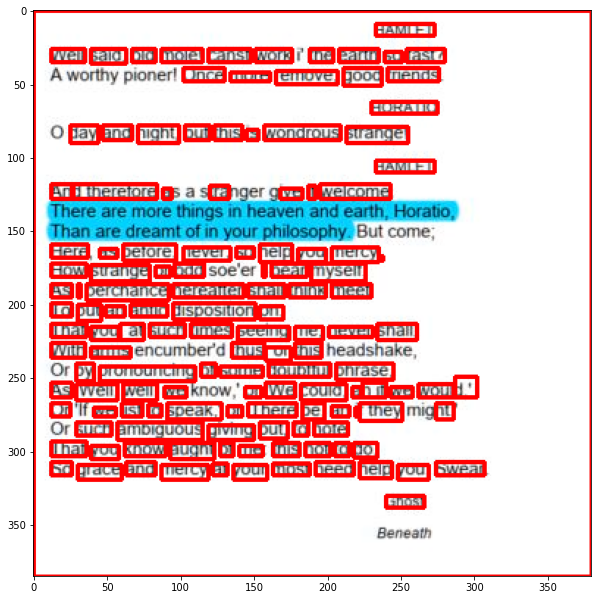

In [16]:
%%time
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2) # RGB

plt.imshow(img)

In [17]:
ext_txt = ''

for i in range(len(d['text'])):
    if int(d['conf'][i]) > 40:
        ext_txt = ext_txt + ' ' + str(d['text'][i])

ext_txt

" HAMLET Well said, old mole! canst work i' the earth so fast? pionerl Once more remove, good friends HORATIO O day and night, but this is wondrous strange! HAMLET And therefore as a strar jive it welcome. Here, as before, never, so help you mercy, How Strange or odd | bear myself, As | perchance hereafter shall think meet To put an antic disposition on, That you, at such times seeing me, never shall, With arms encumber’ thus, or this headshake, (Or by pronouncing of some doubtful phrase, ‘As ‘Well, well, we know,’ or ‘We could, an if we woul (Or 'f we list to speak,’ or There be, an if they migl (Or such ambiguous giving out, to note ‘That you know aught of me: this not to do, So grace and mercy at your most need help you, Swear. Ghost      "

In [18]:
len(ext_txt)

751

In [19]:
# coordinates and some properties

d['left'][8], d['top'][8], d['width'][8], d['height'][8], d['text'][8], d['conf'][8]

(12, 26, 23, 9, 'Well', 84)

In [20]:
d['left'][9], d['top'][9], d['width'][9], d['height'][9], d['text'][9], d['conf'][9]

(39, 26, 24, 10, 'said,', 96)

# OCR Loop

In [21]:
%%time

for folder in folder_list:
  temp_name = os.listdir(path + '/' + folder)

  ## mkkdir
  output_dir = output_path + '/' + folder
  os.mkdir(output_dir)

  for file in temp_name:

    img_loc = path + '/' + folder + '/' + file

    ## pdf format
    if img_loc.endswith('pdf'):
      print("Reading pdf...", img_loc)
      new_name = file[:-4]
      pages = convert_from_path(img_loc)

      ext_txt = '' # clean

      print("Iterating over pdf pages... ", img_loc) # dealing with multi-page pdf
      for page in pages: 
        # display(image_from_pdf[page])
        # page = rgb_to_gray(page) # preprocess

        d = pytesseract.image_to_data(page, output_type = Output.DICT) # OCR for each page 
        
        for i in range(len(d['text'])):
          if int(d['conf'][i]) > 40:
            ext_txt = ext_txt + ' ' + str(d['text'][i])  # concatenate text in page

      print("Exporting extracted text from all pdf pages... ")
      text_file = open(output_dir + '/' + new_name + ".txt", "w")
      text_file.write(ext_txt)
      text_file.close()

    else: # not pdf format

      print("Reading ", img_loc)
      img = cv2.imread(img_loc) # read image
      # image = rgb_to_gray(img) # preprocess

      result = '' # clean result
      d = pytesseract.image_to_data(img, output_type = Output.DICT) # OCR

      print("Concatenating extracted text... ")
      ## concatenate texts
      ext_txt = ''
      for i in range(len(d['text'])):
        if int(d['conf'][i]) > 60:
          ext_txt = ext_txt + ' ' + str(d['text'][i])

      print("Exporting extracted text... ")
      ## export extracted text
      name = file[:-4] # remove extension from name (.png, .jpg, .pdf, .bmp)
      text_file = open(output_dir + '/' + name + ".txt", "w")
      text_file.write(ext_txt)
      text_file.close()

      print("Exporting drawn bboxes... ")
      ## draw bboxes and save (only if not pdf format)
      n_boxes = len(d['text'])
      for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
          (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
          img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2) # BGR
      cv2.imwrite(output_dir + '/' + name + ".png", img)

    print("\n")

Reading  /content/drive/MyDrive/Colab Files/ocr tesseract images/t2/img003.JPG
Concatenating extracted text... 
Exporting extracted text... 
Exporting drawn bboxes... 


Reading pdf... /content/drive/MyDrive/Colab Files/ocr tesseract images/t2/img004.pdf
Iterating over pdf pages...  /content/drive/MyDrive/Colab Files/ocr tesseract images/t2/img004.pdf
Exporting extracted text from all pdf pages... 


Reading  /content/drive/MyDrive/Colab Files/ocr tesseract images/t1/img001.JPG
Concatenating extracted text... 
Exporting extracted text... 
Exporting drawn bboxes... 


Reading  /content/drive/MyDrive/Colab Files/ocr tesseract images/t1/img002.JPG
Concatenating extracted text... 
Exporting extracted text... 
Exporting drawn bboxes... 


CPU times: user 624 ms, sys: 329 ms, total: 953 ms
Wall time: 19.2 s


# Checking output

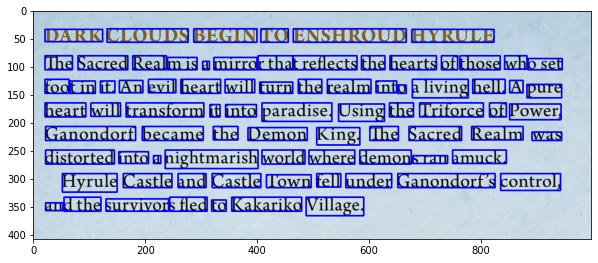

In [22]:
# just checking an exemple of output files (image with drawn bounding boxes)

img_check = cv2.imread('/content/drive/MyDrive/Colab Files/ocr tesseract output/t2/img003.png')
plt.imshow(img_check)

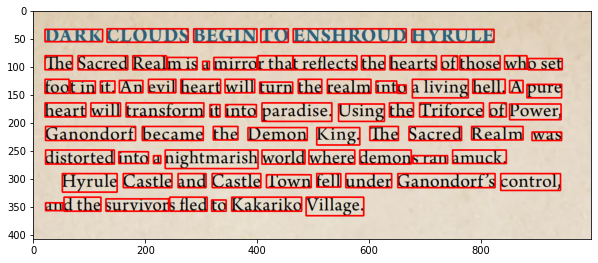

In [23]:
plt.imshow(cv2.cvtColor(img_check, cv2.COLOR_BGR2RGB))

In [24]:
# just checking an exemple of output files (extracted text from image above)

f = open("/content/drive/MyDrive/Colab Files/ocr tesseract output/t2/img003.txt", "r")
print(f.read())

 DARK CLOUDS BEGIN TO ENSHROUD HYRULE The Sacred Realm is a mirror that reflects the hearts of those who set foot in it. An evil heart will turn the realm into a living hell. A pure heart will transform it into paradise. Using the Triforce of Power, Ganondorf became the Demon King. The Sacred Realm was distorted into a nightmarish world where demons ran amuck. Hyrule Castle and Castle Town fell under Ganondorf’s control, and the survivors fled to Kakariko Village.
